In [ ]:
import math
import matplotlib.pyplot as plt
from nltk.tree import Tree
import numpy as np
from copy import deepcopy
import re
import seaborn as sns
from transformers import AutoModel, AutoTokenizer
import torch

/Users/Emma/Desktop/capstone/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [133]:
from copy import deepcopy

In [ ]:
dir = "ch_copy/00/"
doc_id = '0037'

#returns dictionary containing plain sentence, constituency parse and coreference-id-labeled tokens 
def get_sentence_profiles(doc_id):
    profiles = {}
    filename = "ch_" + doc_id + ".onf"
    fp = dir + filename
    with open(fp, "r") as f:
        lines = f.readlines()
    #enumerated = enumerate(lines) -- don't do this
    plain_sent_idxs = [i for i, txt in enumerate(lines) if txt == ("Plain sentence:\n")]
    treebanked_idxs = [i for i, txt in enumerate(lines) if txt.find("Treebanked sentence:\n") > -1]
    tree_idxs = [i for i, txt in enumerate(lines) if txt == ("Tree:\n")]
    leaves_idxs = [i for i, txt in enumerate(lines) if txt == ("Leaves:\n")]

    n_sents = len(plain_sent_idxs)

    for i in range(n_sents):
        profile = doc_id + "_" + str(i)
        profiles[profile] = {}
        profiles[profile]["plain"] = lines[(plain_sent_idxs[i] + 2):treebanked_idxs[i]][0].strip()
        profiles[profile]["plain"] = profiles[profile]["plain"].replace("--", "")
        raw_tree = lines[(tree_idxs[i]+2):leaves_idxs[i]]
        profiles[profile]["tree"] = process_tree(raw_tree)

        if i < n_sents - 1:
            profiles[profile]["leaves"] = lines[(leaves_idxs[i]+2):(plain_sent_idxs[i+1]-3)]
        else:
            profiles[profile]["leaves"] = lines[(leaves_idxs[i]+2):-3]

        profiles[profile]["leaves"] = process_leaves(profiles[profile]["leaves"])

        i += 1
    return profiles

def process_leaves(leafnotes):
    leaves_dict = {}
    i = 0
    for line in leafnotes:
        line = line.strip()
        if len(line) > 0:
            line = line.split()
            if line[0].isdigit():
                if line[1] != "--":
                    leaves_dict[i] = {"token":"", "info": {}}
                    leaves_dict[i]["token"] = line[1]
                    i += 1
            elif i-1 in leaves_dict:
                leaves_dict[i-1]["info"][line[0]] = line[1:]
       
    return leaves_dict

def process_tree(raw_tree):
    tree = ""
    for line in raw_tree:
        tree += line.strip()
    return tree

def get_doc_profile(doc_id):
    profile = {}
    sentence_profiles = get_sentence_profiles(doc_id)
    profile["plain"] = ""
    for id in sentence_profiles:
        profile["plain"] += sentence_profiles[id]["plain"]
    profile["trees"] = [sentence_profiles[profile]["tree"] for profile in sentence_profiles]

    #creates a list of dictionaries containing leafnotes for each sentence
    profile["leaves_per_tree"] = []
    for id in sentence_profiles:
        profile["leaves_per_tree"].append(deepcopy(sentence_profiles[id]["leaves"])) #must deepcopy or dictionaries will merge

    #merged leaves
    profile["leaves"] = sentence_profiles[doc_id + "_0"]["leaves"]
    sentence_profiles_tail = dict(list(sentence_profiles.items())[1:])
    i = list(profile["leaves"].keys())[-1]
    for id in sentence_profiles_tail:
        for leaf in sentence_profiles[id]['leaves']:
            i += 1
            profile["leaves"][i] = sentence_profiles_tail[id]['leaves'][leaf]
    return profile


In [135]:
s_profiles = get_sentence_profiles(doc_id)
doc_profile = get_doc_profile(doc_id)
sample = s_profiles['0037_0']#['plain']

In [237]:
print(doc_profile['leaves'])
print(s_profiles[doc_id+"_0"]["leaves"])

{0: {'token': '*pro*', 'info': {'coref:': ['IDENT', '4', '0-0', '*pro*']}}, 1: {'token': '就', 'info': {}}, 2: {'token': '觉', 'info': {'prop:': ['觉.01'], 'v': ['*', '->', '2:0,', '觉'], 'ARG0': ['*', '->', '0:0,', '*pro*'], 'ARGM-DIS': ['*', '->', '1:1,', '就'], 'ARG1': ['*', '->', '3:3,', '*pro*', '挺', '不', '舒服', '的']}}, 3: {'token': '*pro*', 'info': {'coref:': ['IDENT', '5', '3-3', '*pro*']}}, 4: {'token': '挺', 'info': {}}, 5: {'token': '不', 'info': {}}, 6: {'token': '舒服', 'info': {'prop:': ['舒服.02'], 'v': ['*', '->', '6:0,', '舒服'], 'ARG0': ['*', '->', '3:0,', '*pro*'], 'ARGM-ADV': ['*', '->', '5:1,', '不']}}, 7: {'token': '的', 'info': {}}, 8: {'token': ',', 'info': {}}, 9: {'token': '本来', 'info': {}}, 10: {'token': '就是', 'info': {}}, 11: {'token': '信心', 'info': {}}, 12: {'token': '挺', 'info': {}}, 13: {'token': '足', 'info': {'prop:': ['足.01'], 'v': ['*', '->', '13:0,', '足'], 'ARGM-ADV': ['*', '->', '12:1,', '挺'], 'ARGM-DIS': ['*', '->', '10:1,', '就是'], 'ARG0': ['*', '->', '11:1,', '信心']

In [5]:
#tokenization

##word-level
def get_words(sentence_profile):
    leaves = sentence_profile["leaves"]
    #words = [(idx, leaves[i]["token"]) for idx, i in enumerate(leaves)]
    words = [leaves[i]["token"] for i in leaves]
    return words

##character-level
def get_characters(sentence_profile):
    #characters = [(idx, ch) for idx, ch in enumerate(sentence_profile["plain"])]
    characters = [ch for ch in sentence_profile["plain"]]
    return characters

In [229]:
#set model and tokenizer
model_name = "ckiplab/gpt2-base-chinese" #"hfl/chinese-bert-wwm" #"bert-base-chinese"
tokenizer = "hfl/chinese-bert-wwm"
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained(tokenizer)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

In [230]:
heads = 0
layers = 0

#returns attention weights for specified head, layer
def attention_map(model, text, heads, layers):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    print(torch.stack(outputs.attentions).shape)
    attention_matrix = torch.stack(outputs.attentions)[layers, :, heads, :, :].squeeze(0).detach().numpy()
    print(attention_matrix.shape)
    # = attention[layers.unsqueeze(0), :, heads, :, :]
    #print(selection.shape)
    #aggregate = attention.sum(dim = 0).detach().numpy()
    #print(aggregate.shape)
    
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    print(len(tokens), tokens)
    #punct_idxs = [idx for idx, token in enumerate(tokens) if token in [",", "[CLS]", "[SEP]"]]
    #tokens = [token for i, token in enumerate(tokens) if i not in punct_idxs]
    #attention_matrix = np.delete(attention_matrix, punct_idxs, axis = 1)
    #attention_matrix = np.delete(attention_matrix, punct_idxs, axis = 0)
    
    return attention_matrix #return aggregate.detach().numpy()
    #tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

In [223]:
#returns the index of some verb in the predicate corresponding to the null subject
def get_verb_idx(tree, nsubj_idx):
    t_positions = tree.treepositions(order = 'preorder')
    leaf_positions = [tree.leaf_treeposition(idx) for idx in range(len(tree.leaves()))]
    nsubj_leaf_position = tree.leaf_treeposition(nsubj_idx)
    #print("get_verb_idx nsubj_idx:", nsubj_idx)
    IP_idx = t_positions.index(nsubj_leaf_position) - 1
    IP_pos = t_positions[IP_idx]
    IP_tree = tree[IP_pos]

    while (type(IP_tree) == type("s") or IP_tree.label() not in ['INC', 'IP']):
        IP_idx -= 1
        IP_pos = t_positions[IP_idx]
        IP_tree = tree[IP_pos]

    '''if type(IP_tree) == type("string"):
        print(tree.leaves()[nsubj_idx])
        print(IP_tree)
        print(type(IP_tree), tree)'''
        
    IPt_positions = IP_tree.treepositions(order='preorder')
    mv_idx = None
    for i in range(len(IPt_positions)):
        position = IPt_positions[i]
        if type(IP_tree[position]) == str and ('V' in IP_tree[IPt_positions[i-1]].label() or 'NT' in IP_tree[IPt_positions[i-1]].label()): #to-do: optimize
            #print(IP_tree[IPt_positions[i-1]])
            mv_idx = leaf_positions.index(t_positions[IP_idx + i])
            #print(mv_idx)
            return mv_idx
    
    return None

In [277]:
#Look for layers adhering to Cf rankings
#...examine effect of context_size on first-mention effect
#returns ordered indices of candidate antecedents
'''def mention_sequence(tree):
    lleaves = tree.pos()
    return [(leaf[0], i) for i, leaf in enumerate(lleaves) if "N" in leaf[1] and "*-" not in leaf[0]]'''
def mention_idxs(trees):
    joined_trees_tags = []
    for tree in trees:
        joined_trees_tags += [leaf for leaf in tree.pos()]
    return [idx for idx, leaf in enumerate(joined_trees_tags) if "N" in leaf[1] and "*-" not in leaf[0]]
'''def mention_set(string):
    return set(mention_sequence(string)) #ensure that order is preserved'''

#Hypothesis 1：linear order (looking for first-mention and recency effect) #filter out effect of confound---generate new set of sentences, 
##check if effect disappears w/ bidirectional model
def coref_map(mention_idxs, leafnotes): #convert mention indices to coreference ids
    coref_ids = []
    for idx in mention_idxs:
        #print(idx, leafnotes[idx])
        if "coref:" in leafnotes[idx]["info"]:
            #print(leafnotes[idx]["info"]["coref:"])
            coref_ids.append(int(leafnotes[idx]["info"]["coref:"][1]))
        else:
            coref_ids.append(-1)
    return coref_ids

'''def hyp_1_pred(profile):
     #todo
     return None'''
                
def compare_rankings(hyp_rankings, attn_rankings):
     #diffs = [abs(attn_rankings.index(attn_idx) - hyp_rankings.index(attn_idx)) for attn_idx in attn_rankings]
     print(hyp_rankings)
     print(attn_rankings)
     total_diff = sum([hyp_rankings[i] != attn_rankings[i] for i in range(len(attn_rankings))])
     return total_diff

#to-do: aggregate attentions for each coreference id, then rank and compare with order of coreference ids as predicted by hypothesis

def test_hyp1_doc(profile, attention_maps, context_len=512):

    comparisons = {} #dictionary mapping attention matrix to ranking comparisons
    trees = [Tree.fromstring(tree) for tree in profile["trees"]]
    mentions = mention_idxs(trees)

    nsubj_counter = 0 #keep track of doc-level nsubj positions

    for i in range(len(trees)):
        leafnotes = profile["leaves_per_tree"][i]

        nsubj_idxs = [i for i in leafnotes if leafnotes[i]["token"] == "*pro*" and "info" in leafnotes[i]]

        for nsubj_idx in nsubj_idxs:
            
            #print(mentions)
            n_subj_doc_level_pos = nsubj_idx + nsubj_counter
            candidate_idxs = [idx for idx in mentions if idx < n_subj_doc_level_pos]
            hyp_rankings = coref_map(candidate_idxs, profile['leaves'])
            try:
                verb_idx = get_verb_idx(trees[i], nsubj_idx) + nsubj_counter
            except:
                continue

            if verb_idx > context_len:
                break
            
            for map_idx in range(len(attention_maps)):
                #print(verb_idx)
                candidate_attentions = [(candidate_idx, attention_maps[map_idx][verb_idx][candidate_idx]) for candidate_idx in candidate_idxs]
                #print("candidate attentions:", candidate_attentions)
                idx_ranking = sorted([attn for attn in candidate_attentions], key=lambda tup: tup[1])
                #print("idx_ranking:", idx_ranking)
                attn_ranking = coref_map([tup[0] for tup in idx_ranking], profile['leaves'])
                #print("attn_ranking:",attn_ranking)
                comparison = compare_rankings(hyp_rankings, attn_ranking)
                if map_idx in comparisons:
                    comparisons[map_idx].append(comparison)
                else:
                    comparisons[map_idx] = [comparison]

        nsubj_counter += len(leafnotes)
                
    return comparisons
         
def test_hyp1(profile, attention_maps, doc_level=False, context_len=512):
    
    if doc_level:
         print("whole doc")
         return test_hyp1_doc(profile, attention_maps, context_len)
    else: 
         tree = Tree.fromstring(profile["tree"])
         all_mentions = mention_idxs([tree])

    comparisons = {}
    leafnotes = profile["leaves"]
    print("all mentions:", all_mentions)
    nsubj_idxs = [i for i in leafnotes if leafnotes[i]["token"] == "*pro*" and "info" in leafnotes[i]]
    print("nsubj_idxs:", nsubj_idxs)
    for nsubj_idx in nsubj_idxs:
        verb_idx = get_verb_idx(tree, nsubj_idx)
        print(all_mentions)
        candidate_idxs = [idx for idx in all_mentions if idx < nsubj_idx]
        hyp_idxs = candidate_idxs
        print("nsubj_idx " + str(nsubj_idx))
        print("potential antecedents:", candidate_idxs)
        if verb_idx >= context_len:
            break
        for map in attention_maps:
            candidate_attentions = [(candidate_idx, map[verb_idx][candidate_idx]) for candidate_idx in candidate_idxs]
            idx_ranking = sorted([attn for attn in candidate_attentions], key=lambda tup: tup[1])
            #print("idx_ranking:", idx_ranking)
            attn_ranking = [tup[0] for tup in idx_ranking]
            #print("attn_ranking:", attn_ranking)
            comparison = compare_rankings(hyp_idxs, attn_ranking)
            comparisons.append(comparison)

    return comparisons
            
#to-do: character-level implementation

#Hypothesis 2: grammatical role (ranking by grammatical role)
#to-do: finish implementation

In [27]:
#compares attention rankings to hypothesized rankings
'''def test_hyp_1(profile, attention_maps, is_bidirectional = True):
    tree = Tree.fromstring(profile["tree"])
    leafnotes = profile["leaves"]
    candidate_idxs = mention_idxs(tree)
    nsubj_idxs = [i for i in leafnotes if leafnotes[i]["token"] == "*pro*" and "info" in leafnotes[i]]
    for nsubj_idx in nsubj_idxs:
        verb_idx = get_verb_idx(tree, nsubj_idx)
        candidate_idxs = [idx for idx in candidate_idxs if idx < nsubj_idx]
        for map in attention_maps:
            candidate_attentions = [map[verb_idx][candidate] for candidate in candidate_idxs]
            
            if is_bidirectional:
                candidate_attentions_reverse = [map[candidate][verb_idx] for candidate in candidate_idxs]'''
    #to-do: finish implementation
    
hypotheses = {1: test_hyp_1}      

torch.Size([12, 1, 12, 514, 514])
(514, 514)
514 ['[CLS]', '就', '觉', '挺', '不', '舒', '服', '的', ',', '本', '来', '就', '是', '信', '心', '挺', '足', '的', '.', '啊', '.', '啊', '.', '后', '来', '我', '说', '小', '穗', '啊', ',', '你', '既', '然', '你', '走', '这', '一', '步', '了', '好', ',', '你', '找', '人', '算', '了', '这', '个', '哈', '.', '我', '说', '这', '样', '吧', ',', '我', '说', '我', '认', '识', '一', '个', '人', '就', '是', '起', '那', '个', '八', '卦', '呀', '.', '嗯', '哼', '.', '嗯', '哈', '.', '起', '的', '挺', '准', '的', ',', '他', '就', '是', '说', ',', '就', '说', '某', '一', '件', '事', '儿', ',', '在', '看', '人', '的', '大', '运', '哈', '.', '反', '正', '我', '我', '知', '道', '的', '哈', ',', '他', '说', '我', '和', '我', '认', '识', '这', '些', '人', '哈', ',', '真', '说', '得', '挺', '准', '的', '.', '呃', '哼', '.', '呃', '哈', '.', '呃', '哈', '.', '哦', ',', '是', '吗', '?', '我', '说', '这', '样', '吧', ',', '反', '正', '你', '已', '经', ',', '已', '经', '呃', '就', '是', '算', '过', '了', '哈', '.', '我', '说', '找', '你', '帮', '她', '看', '一', '看', '吧', '.', '晚', '上', '我', '就', '去', '找', '人', '

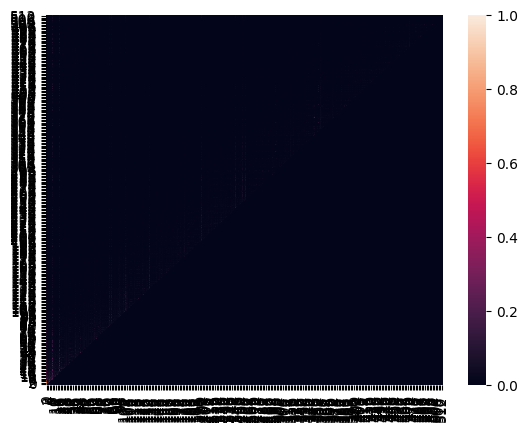

In [231]:
#viewer
attention_matrix = attention_map(model, doc_profile['plain'][:512], heads, layers)
figure = sns.heatmap(attention_matrix, xticklabels=2, yticklabels=2)
figure.invert_yaxis()
plt.show()

In [278]:
print(test_hyp1(doc_profile, [attention_matrix], doc_level=True, context_len = 512))

whole doc
[]
[]
[4]
[4]
[4, 5, -1, 4, 5, 5, 5, -1, 5, -1, -1, -1, 4]
[5, 4, -1, -1, 5, 5, -1, 5, -1, -1, 5, 4, 4]
[4, 5, -1, 4, 5, 5, 5, -1, 5, -1, -1, -1, 4, -1, 4, 4, -1]
[-1, -1, 4, 4, -1, 5, -1, -1, 5, -1, 5, -1, 5, 5, 4, 4, 4]
[4, 5, -1, 4, 5, 5, 5, -1, 5, -1, -1, -1, 4, -1, 4, 4, -1, 16, -1]
[4, -1, 5, -1, -1, -1, 4, 16, -1, -1, 5, -1, 5, 5, -1, 5, 4, 4, 4]
[4, 5, -1, 4, 5, 5, 5, -1, 5, -1, -1, -1, 4, -1, 4, 4, -1, 16, -1, 16, 16, -1, -1, -1, -1, 4, 4, 16, 4, -1, 4, -1]
[-1, 4, -1, -1, 5, -1, -1, -1, -1, 5, 5, -1, 4, 4, -1, -1, 16, 4, 5, -1, -1, 16, 4, 5, 16, 16, 4, 4, -1, -1, 4, 4]
[4, 5, -1, 4, 5, 5, 5, -1, 5, -1, -1, -1, 4, -1, 4, 4, -1, 16, -1, 16, 16, -1, -1, -1, -1, 4, 4, 16, 4, -1, 4, -1, 16]
[4, 16, -1, -1, -1, -1, -1, -1, -1, 16, 4, 5, -1, -1, 5, -1, 16, -1, -1, 16, 5, 5, 4, 4, 5, 16, 4, -1, -1, 4, 4, 4, 4]
[4, 5, -1, 4, 5, 5, 5, -1, 5, -1, -1, -1, 4, -1, 4, 4, -1, 16, -1, 16, 16, -1, -1, -1, -1, 4, 4, 16, 4, -1, 4, -1, 16, -1, 4]
[4, -1, 16, -1, -1, -1, -1, -1, -1, -1, 